In [1]:
!pip install -r ../../requirements.txt

You should consider upgrading via the 'c:\users\falchetto\appdata\local\programs\python\python39\python.exe -m pip install --upgrade pip' command.


# Configuration

In [2]:
ROOT_DIR = "../../"
DATA_DIR = ROOT_DIR + "data/"

DATASET_2016_10a_FILENAME = DATA_DIR + "RML2016.10a_dict.pkl"

NN_NAME = 'CustomBaseline'

DEFAULT_CONFIG_FILENAME = ROOT_DIR + "default.ini"

In [3]:
import configparser

config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

# Imports

In [4]:
import sys
sys.path.append(ROOT_DIR)

import neural_networks
import datasetlib
import traintestsplitlib
import trainlib
import evaluationlib
import dataaugmentationlib

import math

# Dataset

## Dataset in a pandas Dataframe

In [5]:
dataset_df = datasetlib.load_dataset_dataframe(DATASET_2016_10a_FILENAME)

## Raw dataset

In [6]:
dataset_df

,IQ signals,Modulation_Label,SNR
0,"[[-0.0059014712, -0.0023458179, -0.00074506126...",QPSK,2
1,"[[0.0050326153, 0.00094379985, -0.0018932355, ...",QPSK,2
2,"[[0.0052390713, 0.0073890695, 0.007276459, 0.0...",QPSK,2
3,"[[-0.0019859935, -0.0071501383, -0.00527185, -...",QPSK,2
4,"[[0.006674405, 0.0028359746, 0.005630027, 0.00...",QPSK,2
...,...,...,...
219995,"[[0.0062732296, -0.0050519477, 0.006672171, 0....",BPSK,-18
219996,"[[-0.003903181, -0.0015884301, -0.00633375, 2....",BPSK,-18
219997,"[[-0.0105958255, 0.005601244, -0.012161784, 0....",BPSK,-18
219998,"[[-0.002136606, 0.00995837, 0.0059440527, -0.0...",BPSK,-18


# Neural network

## Configuration

In [7]:
config = configparser.ConfigParser()
config.read(DEFAULT_CONFIG_FILENAME)

NEURAL_NETWORK_NAME = config.get('NeuralNetworkNames', NN_NAME)
NEURAL_NETWORK_FILENAME = NEURAL_NETWORK_NAME + '.wts.h5'

TRAINING_SET_DIMENSION = config.getfloat('TrainingValues', 'TrainingSetSplitPercentage')
DROPOUT_RATE = config.getfloat('TrainingValues', 'DropoutRate')

# Set up some params 
NB_EPOCH = config.getint('TrainingValues', 'Epochs') # number of epochs to train on
BATCH_SIZE = config.getint('TrainingValues', 'BatchSize') # training batch size

## Data prepare

In [8]:
signals = datasetlib.signals(dataset_df)
labels = datasetlib.labels(dataset_df)

# [QPSQ, BPSK, ...]
mods = datasetlib.mods(dataset_df)
# [-18, -16, ...]
snrs = datasetlib.unique_snrs(dataset_df)

### Training and Test data partitioning

In [9]:
n_elements = len(signals)
training_set_percentage = TRAINING_SET_DIMENSION

train_index, test_index = traintestsplitlib.train_test_random_indexes(n_elements, training_set_percentage)

X_train, X_test, Y_train, Y_test = traintestsplitlib.split_x_y_train_test(signals, labels, mods, train_index, test_index)

X_train, Y_train = dataaugmentationlib.add_gaussian_noise_and_concatenate_with_signals(X_train, Y_train)

## Build the Neural Network

In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape)
print(in_shp)
classes = mods

(660000, 2, 128)
[2, 128]


In [11]:
model = neural_networks.custom_baseline(in_shp)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IQ (InputLayer)              [(None, 2, 128)]          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 2, 128)            114816    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 2, 128)            82048     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               33024     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896 

### Train the model

In [12]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = NEURAL_NETWORK_FILENAME

history, model = trainlib.train(filepath, model, X_train, Y_train, X_test, Y_test, BATCH_SIZE, NB_EPOCH)

Epoch 1/100


  1/581 [..............................] - ETA: 1:48:47 - loss: 2.3980

  8/581 [..............................] - ETA: 4s - loss: 2.3977     

 16/581 [..............................] - ETA: 4s - loss: 2.3966

 24/581 [>.............................] - ETA: 3s - loss: 2.3934

 33/581 [>.............................] - ETA: 3s - loss: 2.3850

 41/581 [=>............................] - ETA: 3s - loss: 2.3746

 49/581 [=>............................] - ETA: 3s - loss: 2.3638

 57/581 [=>............................] - ETA: 3s - loss: 2.3537

 65/581 [==>...........................] - ETA: 3s - loss: 2.3442

 74/581 [==>...........................] - ETA: 3s - loss: 2.3344

 82/581 [===>..........................] - ETA: 3s - loss: 2.3263

 91/581 [===>..........................] - ETA: 3s - loss: 2.3178

 99/581 [====>.........................] - ETA: 3s - loss: 2.3108

108/581 [====>.........................] - ETA: 3s - loss: 2.3035

116/581 [====>.........................] - ETA: 3s - loss: 2.2975

124/581 [=====>........................] - ETA: 2s - loss: 2.2919

132/581 [=====>........................] - ETA: 2s - loss: 2.2866

140/581 [======>.......................] - ETA: 2s - loss: 2.2817

148/581 [======>.......................] - ETA: 2s - loss: 2.2771

157/581 [=======>......................] - ETA: 2s - loss: 2.2722

165/581 [=======>......................] - ETA: 2s - loss: 2.2680

174/581 [=======>......................] - ETA: 2s - loss: 2.2636

183/581 [========>.....................] - ETA: 2s - loss: 2.2594

192/581 [========>.....................] - ETA: 2s - loss: 2.2554

201/581 [=========>....................] - ETA: 2s - loss: 2.2516

209/581 [=========>....................] - ETA: 2s - loss: 2.2484

217/581 [==========>...................] - ETA: 2s - loss: 2.2453

226/581 [==========>...................] - ETA: 2s - loss: 2.2419

235/581 [===========>..................] - ETA: 2s - loss: 2.2386

244/581 [===========>..................] - ETA: 2s - loss: 2.2354

253/581 [============>.................] - ETA: 2s - loss: 2.2323

262/581 [============>.................] - ETA: 2s - loss: 2.2292

270/581 [============>.................] - ETA: 1s - loss: 2.2266

278/581 [=============>................] - ETA: 1s - loss: 2.2239

287/581 [=============>................] - ETA: 1s - loss: 2.2209

295/581 [==============>...............] - ETA: 1s - loss: 2.2183

304/581 [==============>...............] - ETA: 1s - loss: 2.2153

313/581 [===============>..............] - ETA: 1s - loss: 2.2122

322/581 [===============>..............] - ETA: 1s - loss: 2.2092

331/581 [================>.............] - ETA: 1s - loss: 2.2061

340/581 [================>.............] - ETA: 1s - loss: 2.2031

349/581 [=================>............] - ETA: 1s - loss: 2.2000

357/581 [=================>............] - ETA: 1s - loss: 2.1972

365/581 [=================>............] - ETA: 1s - loss: 2.1945



373/581 [==================>...........] - ETA: 1s - loss: 2.1917

381/581 [==================>...........] - ETA: 1s - loss: 2.1890

389/581 [===================>..........] - ETA: 1s - loss: 2.1862

398/581 [===================>..........] - ETA: 1s - loss: 2.1832

407/581 [====================>.........] - ETA: 1s - loss: 2.1801

416/581 [====================>.........] - ETA: 1s - loss: 2.1770

425/581 [====================>.........] - ETA: 0s - loss: 2.1740

434/581 [=====================>........] - ETA: 0s - loss: 2.1710

442/581 [=====================>........] - ETA: 0s - loss: 2.1683

450/581 [======================>.......] - ETA: 0s - loss: 2.1657

458/581 [======================>.......] - ETA: 0s - loss: 2.1631

467/581 [=======================>......] - ETA: 0s - loss: 2.1601

476/581 [=======================>......] - ETA: 0s - loss: 2.1572

484/581 [=======================>......] - ETA: 0s - loss: 2.1546

493/581 [========================>.....] - ETA: 0s - loss: 2.1518

501/581 [========================>.....] - ETA: 0s - loss: 2.1492

509/581 [=========================>....] - ETA: 0s - loss: 2.1467

518/581 [=========================>....] - ETA: 0s - loss: 2.1439

527/581 [==========================>...] - ETA: 0s - loss: 2.1411

535/581 [==========================>...] - ETA: 0s - loss: 2.1387

543/581 [===========================>..] - ETA: 0s - loss: 2.1363

551/581 [===========================>..] - ETA: 0s - loss: 2.1338

560/581 [===========================>..] - ETA: 0s - loss: 2.1312

568/581 [============================>.] - ETA: 0s - loss: 2.1288

576/581 [============================>.] - ETA: 0s - loss: 2.1264

581/581 [==============================] - ETA: 0s - loss: 2.1250

581/581 [==============================] - 16s 7ms/step - loss: 2.1247 - val_loss: 1.7458


Epoch 2/100
  1/581 [..............................] - ETA: 4s - loss: 1.7568

  9/581 [..............................] - ETA: 3s - loss: 1.7481

 18/581 [..............................] - ETA: 3s - loss: 1.7430

 26/581 [>.............................] - ETA: 3s - loss: 1.7393

 35/581 [>.............................] - ETA: 3s - loss: 1.7378

 43/581 [=>............................] - ETA: 3s - loss: 1.7372

 51/581 [=>............................] - ETA: 3s - loss: 1.7361

 59/581 [==>...........................] - ETA: 3s - loss: 1.7349

 68/581 [==>...........................] - ETA: 3s - loss: 1.7336

 77/581 [==>...........................] - ETA: 3s - loss: 1.7325

 85/581 [===>..........................] - ETA: 3s - loss: 1.7316

 94/581 [===>..........................] - ETA: 3s - loss: 1.7305

103/581 [====>.........................] - ETA: 2s - loss: 1.7296

112/581 [====>.........................] - ETA: 2s - loss: 1.7287

120/581 [=====>........................] - ETA: 2s - loss: 1.7279

129/581 [=====>........................] - ETA: 2s - loss: 1.7271

137/581 [======>.......................] - ETA: 2s - loss: 1.7264

145/581 [======>.......................] - ETA: 2s - loss: 1.7258

154/581 [======>.......................] - ETA: 2s - loss: 1.7252

163/581 [=======>......................] - ETA: 2s - loss: 1.7245

171/581 [=======>......................] - ETA: 2s - loss: 1.7239



179/581 [========>.....................] - ETA: 2s - loss: 1.7234

188/581 [========>.....................] - ETA: 2s - loss: 1.7228

197/581 [=========>....................] - ETA: 2s - loss: 1.7222

205/581 [=========>....................] - ETA: 2s - loss: 1.7217

213/581 [=========>....................] - ETA: 2s - loss: 1.7212

221/581 [==========>...................] - ETA: 2s - loss: 1.7208

230/581 [==========>...................] - ETA: 2s - loss: 1.7202

239/581 [===========>..................] - ETA: 2s - loss: 1.7197

247/581 [===========>..................] - ETA: 2s - loss: 1.7192

255/581 [============>.................] - ETA: 2s - loss: 1.7188

264/581 [============>.................] - ETA: 1s - loss: 1.7183

273/581 [=============>................] - ETA: 1s - loss: 1.7177

281/581 [=============>................] - ETA: 1s - loss: 1.7172

289/581 [=============>................] - ETA: 1s - loss: 1.7167

297/581 [==============>...............] - ETA: 1s - loss: 1.7163

305/581 [==============>...............] - ETA: 1s - loss: 1.7158

314/581 [===============>..............] - ETA: 1s - loss: 1.7152

323/581 [===============>..............] - ETA: 1s - loss: 1.7147

331/581 [================>.............] - ETA: 1s - loss: 1.7143

340/581 [================>.............] - ETA: 1s - loss: 1.7137

349/581 [=================>............] - ETA: 1s - loss: 1.7132



357/581 [=================>............] - ETA: 1s - loss: 1.7128

366/581 [=================>............] - ETA: 1s - loss: 1.7123

374/581 [==================>...........] - ETA: 1s - loss: 1.7119

382/581 [==================>...........] - ETA: 1s - loss: 1.7114

391/581 [===================>..........] - ETA: 1s - loss: 1.7110

399/581 [===================>..........] - ETA: 1s - loss: 1.7105

407/581 [====================>.........] - ETA: 1s - loss: 1.7101

416/581 [====================>.........] - ETA: 1s - loss: 1.7096

425/581 [====================>.........] - ETA: 0s - loss: 1.7092

434/581 [=====================>........] - ETA: 0s - loss: 1.7087

443/581 [=====================>........] - ETA: 0s - loss: 1.7082

452/581 [======================>.......] - ETA: 0s - loss: 1.7077

461/581 [======================>.......] - ETA: 0s - loss: 1.7072

469/581 [=======================>......] - ETA: 0s - loss: 1.7068

478/581 [=======================>......] - ETA: 0s - loss: 1.7063

486/581 [========================>.....] - ETA: 0s - loss: 1.7059

494/581 [========================>.....] - ETA: 0s - loss: 1.7055

503/581 [========================>.....] - ETA: 0s - loss: 1.7050

512/581 [=========================>....] - ETA: 0s - loss: 1.7046

521/581 [=========================>....] - ETA: 0s - loss: 1.7041

530/581 [==========================>...] - ETA: 0s - loss: 1.7036

539/581 [==========================>...] - ETA: 0s - loss: 1.7032

548/581 [===========================>..] - ETA: 0s - loss: 1.7027

556/581 [===========================>..] - ETA: 0s - loss: 1.7023

564/581 [============================>.] - ETA: 0s - loss: 1.7019

572/581 [============================>.] - ETA: 0s - loss: 1.7015

581/581 [==============================] - ETA: 0s - loss: 1.7010

581/581 [==============================] - 4s 7ms/step - loss: 1.7010 - val_loss: 1.6247


Epoch 3/100
  1/581 [..............................] - ETA: 5s - loss: 1.6251

  9/581 [..............................] - ETA: 3s - loss: 1.6157

 17/581 [..............................] - ETA: 3s - loss: 1.6144

 25/581 [>.............................] - ETA: 3s - loss: 1.6132

 33/581 [>.............................] - ETA: 3s - loss: 1.6121

 42/581 [=>............................] - ETA: 3s - loss: 1.6115

 50/581 [=>............................] - ETA: 3s - loss: 1.6109

 59/581 [==>...........................] - ETA: 3s - loss: 1.6106

 68/581 [==>...........................] - ETA: 3s - loss: 1.6105

 77/581 [==>...........................] - ETA: 3s - loss: 1.6103

 85/581 [===>..........................] - ETA: 3s - loss: 1.6101

 93/581 [===>..........................] - ETA: 3s - loss: 1.6098



101/581 [====>.........................] - ETA: 3s - loss: 1.6093

110/581 [====>.........................] - ETA: 2s - loss: 1.6088

119/581 [=====>........................] - ETA: 2s - loss: 1.6083

128/581 [=====>........................] - ETA: 2s - loss: 1.6077

137/581 [======>.......................] - ETA: 2s - loss: 1.6072

146/581 [======>.......................] - ETA: 2s - loss: 1.6066

155/581 [=======>......................] - ETA: 2s - loss: 1.6062

163/581 [=======>......................] - ETA: 2s - loss: 1.6058

172/581 [=======>......................] - ETA: 2s - loss: 1.6053

181/581 [========>.....................] - ETA: 2s - loss: 1.6049

189/581 [========>.....................] - ETA: 2s - loss: 1.6045

197/581 [=========>....................] - ETA: 2s - loss: 1.6041

205/581 [=========>....................] - ETA: 2s - loss: 1.6036

213/581 [=========>....................] - ETA: 2s - loss: 1.6032

222/581 [==========>...................] - ETA: 2s - loss: 1.6027

230/581 [==========>...................] - ETA: 2s - loss: 1.6023

238/581 [===========>..................] - ETA: 2s - loss: 1.6019

247/581 [===========>..................] - ETA: 2s - loss: 1.6014

255/581 [============>.................] - ETA: 2s - loss: 1.6010

263/581 [============>.................] - ETA: 1s - loss: 1.6006

271/581 [============>.................] - ETA: 1s - loss: 1.6003

279/581 [=============>................] - ETA: 1s - loss: 1.5999

288/581 [=============>................] - ETA: 1s - loss: 1.5995

297/581 [==============>...............] - ETA: 1s - loss: 1.5990

306/581 [==============>...............] - ETA: 1s - loss: 1.5986

315/581 [===============>..............] - ETA: 1s - loss: 1.5982

324/581 [===============>..............] - ETA: 1s - loss: 1.5978

333/581 [================>.............] - ETA: 1s - loss: 1.5974

342/581 [================>.............] - ETA: 1s - loss: 1.5970

350/581 [=================>............] - ETA: 1s - loss: 1.5966

359/581 [=================>............] - ETA: 1s - loss: 1.5962

367/581 [=================>............] - ETA: 1s - loss: 1.5959

376/581 [==================>...........] - ETA: 1s - loss: 1.5954

385/581 [==================>...........] - ETA: 1s - loss: 1.5950

394/581 [===================>..........] - ETA: 1s - loss: 1.5946

403/581 [===================>..........] - ETA: 1s - loss: 1.5941

411/581 [====================>.........] - ETA: 1s - loss: 1.5938

419/581 [====================>.........] - ETA: 1s - loss: 1.5934

427/581 [=====================>........] - ETA: 0s - loss: 1.5930

436/581 [=====================>........] - ETA: 0s - loss: 1.5926

445/581 [=====================>........] - ETA: 0s - loss: 1.5922

454/581 [======================>.......] - ETA: 0s - loss: 1.5917

463/581 [======================>.......] - ETA: 0s - loss: 1.5913

471/581 [=======================>......] - ETA: 0s - loss: 1.5909

479/581 [=======================>......] - ETA: 0s - loss: 1.5906

487/581 [========================>.....] - ETA: 0s - loss: 1.5902

495/581 [========================>.....] - ETA: 0s - loss: 1.5898

504/581 [=========================>....] - ETA: 0s - loss: 1.5894

512/581 [=========================>....] - ETA: 0s - loss: 1.5890

520/581 [=========================>....] - ETA: 0s - loss: 1.5886

528/581 [==========================>...] - ETA: 0s - loss: 1.5882

537/581 [==========================>...] - ETA: 0s - loss: 1.5878

545/581 [===========================>..] - ETA: 0s - loss: 1.5874

553/581 [===========================>..] - ETA: 0s - loss: 1.5870

562/581 [============================>.] - ETA: 0s - loss: 1.5866

571/581 [============================>.] - ETA: 0s - loss: 1.5862

579/581 [============================>.] - ETA: 0s - loss: 1.5858

581/581 [==============================] - 4s 7ms/step - loss: 1.5856 - val_loss: 1.5316


Epoch 4/100
  1/581 [..............................] - ETA: 3s - loss: 1.5127

  9/581 [..............................] - ETA: 3s - loss: 1.5082

 18/581 [..............................] - ETA: 3s - loss: 1.5073

 26/581 [>.............................] - ETA: 3s - loss: 1.5082

 35/581 [>.............................] - ETA: 3s - loss: 1.5075

 44/581 [=>............................] - ETA: 3s - loss: 1.5058

 52/581 [=>............................] - ETA: 3s - loss: 1.5041

 60/581 [==>...........................] - ETA: 3s - loss: 1.5028

 68/581 [==>...........................] - ETA: 3s - loss: 1.5018

 77/581 [==>...........................] - ETA: 3s - loss: 1.5007

 85/581 [===>..........................] - ETA: 3s - loss: 1.4999



 93/581 [===>..........................] - ETA: 3s - loss: 1.4991

101/581 [====>.........................] - ETA: 3s - loss: 1.4982

110/581 [====>.........................] - ETA: 2s - loss: 1.4973

118/581 [=====>........................] - ETA: 2s - loss: 1.4965

126/581 [=====>........................] - ETA: 2s - loss: 1.4958

134/581 [=====>........................] - ETA: 2s - loss: 1.4952

142/581 [======>.......................] - ETA: 2s - loss: 1.4946

150/581 [======>.......................] - ETA: 2s - loss: 1.4940

158/581 [=======>......................] - ETA: 2s - loss: 1.4935

166/581 [=======>......................] - ETA: 2s - loss: 1.4929

174/581 [=======>......................] - ETA: 2s - loss: 1.4924

183/581 [========>.....................] - ETA: 2s - loss: 1.4919

192/581 [========>.....................] - ETA: 2s - loss: 1.4913

201/581 [=========>....................] - ETA: 2s - loss: 1.4908

209/581 [=========>....................] - ETA: 2s - loss: 1.4903

218/581 [==========>...................] - ETA: 2s - loss: 1.4898

227/581 [==========>...................] - ETA: 2s - loss: 1.4893

236/581 [===========>..................] - ETA: 2s - loss: 1.4888

244/581 [===========>..................] - ETA: 2s - loss: 1.4883



253/581 [============>.................] - ETA: 2s - loss: 1.4878

261/581 [============>.................] - ETA: 2s - loss: 1.4874

270/581 [============>.................] - ETA: 1s - loss: 1.4869

278/581 [=============>................] - ETA: 1s - loss: 1.4864

287/581 [=============>................] - ETA: 1s - loss: 1.4860

295/581 [==============>...............] - ETA: 1s - loss: 1.4855

303/581 [==============>...............] - ETA: 1s - loss: 1.4851

311/581 [===============>..............] - ETA: 1s - loss: 1.4847

320/581 [===============>..............] - ETA: 1s - loss: 1.4842

328/581 [===============>..............] - ETA: 1s - loss: 1.4838

336/581 [================>.............] - ETA: 1s - loss: 1.4834

345/581 [================>.............] - ETA: 1s - loss: 1.4830

354/581 [=================>............] - ETA: 1s - loss: 1.4826

363/581 [=================>............] - ETA: 1s - loss: 1.4821

371/581 [==================>...........] - ETA: 1s - loss: 1.4818

379/581 [==================>...........] - ETA: 1s - loss: 1.4814

388/581 [===================>..........] - ETA: 1s - loss: 1.4810

396/581 [===================>..........] - ETA: 1s - loss: 1.4806

405/581 [===================>..........] - ETA: 1s - loss: 1.4802

414/581 [====================>.........] - ETA: 1s - loss: 1.4798

423/581 [====================>.........] - ETA: 0s - loss: 1.4794

432/581 [=====================>........] - ETA: 0s - loss: 1.4791

440/581 [=====================>........] - ETA: 0s - loss: 1.4787

448/581 [======================>.......] - ETA: 0s - loss: 1.4784

457/581 [======================>.......] - ETA: 0s - loss: 1.4780

466/581 [=======================>......] - ETA: 0s - loss: 1.4776

474/581 [=======================>......] - ETA: 0s - loss: 1.4773

482/581 [=======================>......] - ETA: 0s - loss: 1.4770

490/581 [========================>.....] - ETA: 0s - loss: 1.4767

498/581 [========================>.....] - ETA: 0s - loss: 1.4764

506/581 [=========================>....] - ETA: 0s - loss: 1.4760

514/581 [=========================>....] - ETA: 0s - loss: 1.4757

522/581 [=========================>....] - ETA: 0s - loss: 1.4754

530/581 [==========================>...] - ETA: 0s - loss: 1.4751

538/581 [==========================>...] - ETA: 0s - loss: 1.4748

546/581 [===========================>..] - ETA: 0s - loss: 1.4745

555/581 [===========================>..] - ETA: 0s - loss: 1.4742

564/581 [============================>.] - ETA: 0s - loss: 1.4738

573/581 [============================>.] - ETA: 0s - loss: 1.4735

581/581 [==============================] - 4s 7ms/step - loss: 1.4732 - val_loss: 1.4625


Epoch 5/100
  1/581 [..............................] - ETA: 6s - loss: 1.4223

  9/581 [..............................] - ETA: 3s - loss: 1.4335

 17/581 [..............................] - ETA: 3s - loss: 1.4292

 26/581 [>.............................] - ETA: 3s - loss: 1.4252

 35/581 [>.............................] - ETA: 3s - loss: 1.4216

 43/581 [=>............................] - ETA: 3s - loss: 1.4194

 51/581 [=>............................] - ETA: 3s - loss: 1.4180

 60/581 [==>...........................] - ETA: 3s - loss: 1.4169

 69/581 [==>...........................] - ETA: 3s - loss: 1.4159

 77/581 [==>...........................] - ETA: 3s - loss: 1.4154

 85/581 [===>..........................] - ETA: 3s - loss: 1.4148

 94/581 [===>..........................] - ETA: 3s - loss: 1.4143

103/581 [====>.........................] - ETA: 3s - loss: 1.4138

111/581 [====>.........................] - ETA: 2s - loss: 1.4135

120/581 [=====>........................] - ETA: 2s - loss: 1.4132

128/581 [=====>........................] - ETA: 2s - loss: 1.4130

137/581 [======>.......................] - ETA: 2s - loss: 1.4127

145/581 [======>.......................] - ETA: 2s - loss: 1.4125

154/581 [======>.......................] - ETA: 2s - loss: 1.4122

163/581 [=======>......................] - ETA: 2s - loss: 1.4120

172/581 [=======>......................] - ETA: 2s - loss: 1.4117

181/581 [========>.....................] - ETA: 2s - loss: 1.4114

190/581 [========>.....................] - ETA: 2s - loss: 1.4111

199/581 [=========>....................] - ETA: 2s - loss: 1.4109

208/581 [=========>....................] - ETA: 2s - loss: 1.4106

216/581 [==========>...................] - ETA: 2s - loss: 1.4104

224/581 [==========>...................] - ETA: 2s - loss: 1.4102

232/581 [==========>...................] - ETA: 2s - loss: 1.4100

240/581 [===========>..................] - ETA: 2s - loss: 1.4098

248/581 [===========>..................] - ETA: 2s - loss: 1.4096

257/581 [============>.................] - ETA: 2s - loss: 1.4094

266/581 [============>.................] - ETA: 1s - loss: 1.4092

275/581 [=============>................] - ETA: 1s - loss: 1.4089

284/581 [=============>................] - ETA: 1s - loss: 1.4087

292/581 [==============>...............] - ETA: 1s - loss: 1.4085

301/581 [==============>...............] - ETA: 1s - loss: 1.4083

310/581 [===============>..............] - ETA: 1s - loss: 1.4081

318/581 [===============>..............] - ETA: 1s - loss: 1.4079

327/581 [===============>..............] - ETA: 1s - loss: 1.4077

335/581 [================>.............] - ETA: 1s - loss: 1.4075

344/581 [================>.............] - ETA: 1s - loss: 1.4074

352/581 [=================>............] - ETA: 1s - loss: 1.4072

361/581 [=================>............] - ETA: 1s - loss: 1.4070

370/581 [==================>...........] - ETA: 1s - loss: 1.4068

378/581 [==================>...........] - ETA: 1s - loss: 1.4067

387/581 [==================>...........] - ETA: 1s - loss: 1.4065

395/581 [===================>..........] - ETA: 1s - loss: 1.4064

404/581 [===================>..........] - ETA: 1s - loss: 1.4062

412/581 [====================>.........] - ETA: 1s - loss: 1.4061

421/581 [====================>.........] - ETA: 1s - loss: 1.4059

430/581 [=====================>........] - ETA: 0s - loss: 1.4058

439/581 [=====================>........] - ETA: 0s - loss: 1.4056

447/581 [======================>.......] - ETA: 0s - loss: 1.4055

455/581 [======================>.......] - ETA: 0s - loss: 1.4054

464/581 [======================>.......] - ETA: 0s - loss: 1.4052

473/581 [=======================>......] - ETA: 0s - loss: 1.4050

481/581 [=======================>......] - ETA: 0s - loss: 1.4049

490/581 [========================>.....] - ETA: 0s - loss: 1.4048

499/581 [========================>.....] - ETA: 0s - loss: 1.4046

508/581 [=========================>....] - ETA: 0s - loss: 1.4045

516/581 [=========================>....] - ETA: 0s - loss: 1.4044

525/581 [==========================>...] - ETA: 0s - loss: 1.4042

533/581 [==========================>...] - ETA: 0s - loss: 1.4041



541/581 [==========================>...] - ETA: 0s - loss: 1.4040

549/581 [===========================>..] - ETA: 0s - loss: 1.4039

558/581 [===========================>..] - ETA: 0s - loss: 1.4037

567/581 [============================>.] - ETA: 0s - loss: 1.4036

575/581 [============================>.] - ETA: 0s - loss: 1.4035

581/581 [==============================] - 4s 7ms/step - loss: 1.4034 - val_loss: 1.4340


Epoch 6/100
  1/581 [..............................] - ETA: 4s - loss: 1.3846

  9/581 [..............................] - ETA: 3s - loss: 1.3744

 18/581 [..............................] - ETA: 3s - loss: 1.3740

 27/581 [>.............................] - ETA: 3s - loss: 1.3739

 36/581 [>.............................] - ETA: 3s - loss: 1.3737

 45/581 [=>............................] - ETA: 3s - loss: 1.3736

 54/581 [=>............................] - ETA: 3s - loss: 1.3737

 63/581 [==>...........................] - ETA: 3s - loss: 1.3737

 71/581 [==>...........................] - ETA: 3s - loss: 1.3739

 80/581 [===>..........................] - ETA: 3s - loss: 1.3742

 89/581 [===>..........................] - ETA: 3s - loss: 1.3744

 98/581 [====>.........................] - ETA: 2s - loss: 1.3745

106/581 [====>.........................] - ETA: 2s - loss: 1.3745

114/581 [====>.........................] - ETA: 2s - loss: 1.3744

122/581 [=====>........................] - ETA: 2s - loss: 1.3743

130/581 [=====>........................] - ETA: 2s - loss: 1.3742

138/581 [======>.......................] - ETA: 2s - loss: 1.3741

146/581 [======>.......................] - ETA: 2s - loss: 1.3739

154/581 [======>.......................] - ETA: 2s - loss: 1.3737

163/581 [=======>......................] - ETA: 2s - loss: 1.3735

171/581 [=======>......................] - ETA: 2s - loss: 1.3733

179/581 [========>.....................] - ETA: 2s - loss: 1.3732

188/581 [========>.....................] - ETA: 2s - loss: 1.3730

197/581 [=========>....................] - ETA: 2s - loss: 1.3728

206/581 [=========>....................] - ETA: 2s - loss: 1.3726

214/581 [==========>...................] - ETA: 2s - loss: 1.3724

223/581 [==========>...................] - ETA: 2s - loss: 1.3721

231/581 [==========>...................] - ETA: 2s - loss: 1.3719

239/581 [===========>..................] - ETA: 2s - loss: 1.3717

248/581 [===========>..................] - ETA: 2s - loss: 1.3715

256/581 [============>.................] - ETA: 2s - loss: 1.3713

265/581 [============>.................] - ETA: 1s - loss: 1.3712

273/581 [=============>................] - ETA: 1s - loss: 1.3710

282/581 [=============>................] - ETA: 1s - loss: 1.3709

290/581 [=============>................] - ETA: 1s - loss: 1.3707

298/581 [==============>...............] - ETA: 1s - loss: 1.3706

306/581 [==============>...............] - ETA: 1s - loss: 1.3704

314/581 [===============>..............] - ETA: 1s - loss: 1.3703

322/581 [===============>..............] - ETA: 1s - loss: 1.3702

330/581 [================>.............] - ETA: 1s - loss: 1.3700

338/581 [================>.............] - ETA: 1s - loss: 1.3699

346/581 [================>.............] - ETA: 1s - loss: 1.3698

354/581 [=================>............] - ETA: 1s - loss: 1.3697

362/581 [=================>............] - ETA: 1s - loss: 1.3696

371/581 [==================>...........] - ETA: 1s - loss: 1.3694

379/581 [==================>...........] - ETA: 1s - loss: 1.3693

387/581 [==================>...........] - ETA: 1s - loss: 1.3692

395/581 [===================>..........] - ETA: 1s - loss: 1.3691

403/581 [===================>..........] - ETA: 1s - loss: 1.3690

411/581 [====================>.........] - ETA: 1s - loss: 1.3689

419/581 [====================>.........] - ETA: 1s - loss: 1.3688

427/581 [=====================>........] - ETA: 0s - loss: 1.3687

435/581 [=====================>........] - ETA: 0s - loss: 1.3687

443/581 [=====================>........] - ETA: 0s - loss: 1.3686

451/581 [======================>.......] - ETA: 0s - loss: 1.3685

459/581 [======================>.......] - ETA: 0s - loss: 1.3684

467/581 [=======================>......] - ETA: 0s - loss: 1.3683

475/581 [=======================>......] - ETA: 0s - loss: 1.3682

484/581 [=======================>......] - ETA: 0s - loss: 1.3681

492/581 [========================>.....] - ETA: 0s - loss: 1.3680

500/581 [========================>.....] - ETA: 0s - loss: 1.3679

508/581 [=========================>....] - ETA: 0s - loss: 1.3678

517/581 [=========================>....] - ETA: 0s - loss: 1.3677

525/581 [==========================>...] - ETA: 0s - loss: 1.3677

534/581 [==========================>...] - ETA: 0s - loss: 1.3675

542/581 [==========================>...] - ETA: 0s - loss: 1.3675

550/581 [===========================>..] - ETA: 0s - loss: 1.3674

558/581 [===========================>..] - ETA: 0s - loss: 1.3673

566/581 [============================>.] - ETA: 0s - loss: 1.3672

574/581 [============================>.] - ETA: 0s - loss: 1.3671

581/581 [==============================] - 4s 7ms/step - loss: 1.3670 - val_loss: 1.4166


Epoch 7/100
  1/581 [..............................] - ETA: 4s - loss: 1.3681

  9/581 [..............................] - ETA: 3s - loss: 1.3546

 18/581 [..............................] - ETA: 3s - loss: 1.3520

 26/581 [>.............................] - ETA: 3s - loss: 1.3507

 34/581 [>.............................] - ETA: 3s - loss: 1.3488

 43/581 [=>............................] - ETA: 3s - loss: 1.3472

 51/581 [=>............................] - ETA: 3s - loss: 1.3461

 60/581 [==>...........................] - ETA: 3s - loss: 1.3451

 68/581 [==>...........................] - ETA: 3s - loss: 1.3443

 76/581 [==>...........................] - ETA: 3s - loss: 1.3436

 84/581 [===>..........................] - ETA: 3s - loss: 1.3429

 92/581 [===>..........................] - ETA: 3s - loss: 1.3423

100/581 [====>.........................] - ETA: 3s - loss: 1.3419

108/581 [====>.........................] - ETA: 3s - loss: 1.3416

116/581 [====>.........................] - ETA: 2s - loss: 1.3413

125/581 [=====>........................] - ETA: 2s - loss: 1.3412

133/581 [=====>........................] - ETA: 2s - loss: 1.3410

142/581 [======>.......................] - ETA: 2s - loss: 1.3408

150/581 [======>.......................] - ETA: 2s - loss: 1.3407

159/581 [=======>......................] - ETA: 2s - loss: 1.3405

167/581 [=======>......................] - ETA: 2s - loss: 1.3404

176/581 [========>.....................] - ETA: 2s - loss: 1.3402

184/581 [========>.....................] - ETA: 2s - loss: 1.3401

193/581 [========>.....................] - ETA: 2s - loss: 1.3399

201/581 [=========>....................] - ETA: 2s - loss: 1.3398

209/581 [=========>....................] - ETA: 2s - loss: 1.3397

217/581 [==========>...................] - ETA: 2s - loss: 1.3397

225/581 [==========>...................] - ETA: 2s - loss: 1.3396

233/581 [===========>..................] - ETA: 2s - loss: 1.3396

241/581 [===========>..................] - ETA: 2s - loss: 1.3395

249/581 [===========>..................] - ETA: 2s - loss: 1.3395

257/581 [============>.................] - ETA: 2s - loss: 1.3395

265/581 [============>.................] - ETA: 2s - loss: 1.3394

274/581 [=============>................] - ETA: 1s - loss: 1.3394

282/581 [=============>................] - ETA: 1s - loss: 1.3393

290/581 [=============>................] - ETA: 1s - loss: 1.3393

298/581 [==============>...............] - ETA: 1s - loss: 1.3393

306/581 [==============>...............] - ETA: 1s - loss: 1.3392



314/581 [===============>..............] - ETA: 1s - loss: 1.3392

322/581 [===============>..............] - ETA: 1s - loss: 1.3392

330/581 [================>.............] - ETA: 1s - loss: 1.3391

338/581 [================>.............] - ETA: 1s - loss: 1.3391

347/581 [================>.............] - ETA: 1s - loss: 1.3390

355/581 [=================>............] - ETA: 1s - loss: 1.3390

363/581 [=================>............] - ETA: 1s - loss: 1.3389

371/581 [==================>...........] - ETA: 1s - loss: 1.3389

379/581 [==================>...........] - ETA: 1s - loss: 1.3389

387/581 [==================>...........] - ETA: 1s - loss: 1.3388

395/581 [===================>..........] - ETA: 1s - loss: 1.3388

403/581 [===================>..........] - ETA: 1s - loss: 1.3387

411/581 [====================>.........] - ETA: 1s - loss: 1.3387

419/581 [====================>.........] - ETA: 1s - loss: 1.3387

427/581 [=====================>........] - ETA: 0s - loss: 1.3386

435/581 [=====================>........] - ETA: 0s - loss: 1.3386

443/581 [=====================>........] - ETA: 0s - loss: 1.3386

451/581 [======================>.......] - ETA: 0s - loss: 1.3385

460/581 [======================>.......] - ETA: 0s - loss: 1.3385

468/581 [=======================>......] - ETA: 0s - loss: 1.3384

476/581 [=======================>......] - ETA: 0s - loss: 1.3384

484/581 [=======================>......] - ETA: 0s - loss: 1.3384

492/581 [========================>.....] - ETA: 0s - loss: 1.3383

501/581 [========================>.....] - ETA: 0s - loss: 1.3383

510/581 [=========================>....] - ETA: 0s - loss: 1.3383

518/581 [=========================>....] - ETA: 0s - loss: 1.3382

526/581 [==========================>...] - ETA: 0s - loss: 1.3382

534/581 [==========================>...] - ETA: 0s - loss: 1.3382

542/581 [==========================>...] - ETA: 0s - loss: 1.3382

551/581 [===========================>..] - ETA: 0s - loss: 1.3381

559/581 [===========================>..] - ETA: 0s - loss: 1.3381

567/581 [============================>.] - ETA: 0s - loss: 1.3381

575/581 [============================>.] - ETA: 0s - loss: 1.3381

581/581 [==============================] - 4s 7ms/step - loss: 1.3381 - val_loss: 1.4080


Epoch 8/100
  1/581 [..............................] - ETA: 4s - loss: 1.3373

  9/581 [..............................] - ETA: 3s - loss: 1.3165

 17/581 [..............................] - ETA: 3s - loss: 1.3186

 25/581 [>.............................] - ETA: 3s - loss: 1.3188

 33/581 [>.............................] - ETA: 3s - loss: 1.3178

 41/581 [=>............................] - ETA: 3s - loss: 1.3172

 49/581 [=>............................] - ETA: 3s - loss: 1.3166

 57/581 [=>............................] - ETA: 3s - loss: 1.3163

 65/581 [==>...........................] - ETA: 3s - loss: 1.3162

 74/581 [==>...........................] - ETA: 3s - loss: 1.3160

 83/581 [===>..........................] - ETA: 3s - loss: 1.3157

 92/581 [===>..........................] - ETA: 3s - loss: 1.3157

100/581 [====>.........................] - ETA: 3s - loss: 1.3156

108/581 [====>.........................] - ETA: 3s - loss: 1.3156

116/581 [====>.........................] - ETA: 2s - loss: 1.3155

124/581 [=====>........................] - ETA: 2s - loss: 1.3155

133/581 [=====>........................] - ETA: 2s - loss: 1.3155

141/581 [======>.......................] - ETA: 2s - loss: 1.3154

149/581 [======>.......................] - ETA: 2s - loss: 1.3153

157/581 [=======>......................] - ETA: 2s - loss: 1.3153

165/581 [=======>......................] - ETA: 2s - loss: 1.3152



173/581 [=======>......................] - ETA: 2s - loss: 1.3152

181/581 [========>.....................] - ETA: 2s - loss: 1.3152

189/581 [========>.....................] - ETA: 2s - loss: 1.3152

197/581 [=========>....................] - ETA: 2s - loss: 1.3152

205/581 [=========>....................] - ETA: 2s - loss: 1.3152

213/581 [=========>....................] - ETA: 2s - loss: 1.3152

221/581 [==========>...................] - ETA: 2s - loss: 1.3153

229/581 [==========>...................] - ETA: 2s - loss: 1.3153

237/581 [===========>..................] - ETA: 2s - loss: 1.3153

245/581 [===========>..................] - ETA: 2s - loss: 1.3154

253/581 [============>.................] - ETA: 2s - loss: 1.3154

261/581 [============>.................] - ETA: 2s - loss: 1.3154

269/581 [============>.................] - ETA: 2s - loss: 1.3154

278/581 [=============>................] - ETA: 1s - loss: 1.3154

287/581 [=============>................] - ETA: 1s - loss: 1.3154

295/581 [==============>...............] - ETA: 1s - loss: 1.3154

303/581 [==============>...............] - ETA: 1s - loss: 1.3154

311/581 [===============>..............] - ETA: 1s - loss: 1.3154

319/581 [===============>..............] - ETA: 1s - loss: 1.3154

327/581 [===============>..............] - ETA: 1s - loss: 1.3154

335/581 [================>.............] - ETA: 1s - loss: 1.3154

343/581 [================>.............] - ETA: 1s - loss: 1.3154

352/581 [=================>............] - ETA: 1s - loss: 1.3154

360/581 [=================>............] - ETA: 1s - loss: 1.3154

368/581 [==================>...........] - ETA: 1s - loss: 1.3154

376/581 [==================>...........] - ETA: 1s - loss: 1.3154

384/581 [==================>...........] - ETA: 1s - loss: 1.3154

392/581 [===================>..........] - ETA: 1s - loss: 1.3154

400/581 [===================>..........] - ETA: 1s - loss: 1.3154

409/581 [====================>.........] - ETA: 1s - loss: 1.3154

417/581 [====================>.........] - ETA: 1s - loss: 1.3154

425/581 [====================>.........] - ETA: 1s - loss: 1.3155

433/581 [=====================>........] - ETA: 0s - loss: 1.3155

441/581 [=====================>........] - ETA: 0s - loss: 1.3155

449/581 [======================>.......] - ETA: 0s - loss: 1.3155

457/581 [======================>.......] - ETA: 0s - loss: 1.3155

465/581 [=======================>......] - ETA: 0s - loss: 1.3155

473/581 [=======================>......] - ETA: 0s - loss: 1.3155

481/581 [=======================>......] - ETA: 0s - loss: 1.3155

489/581 [========================>.....] - ETA: 0s - loss: 1.3155

497/581 [========================>.....] - ETA: 0s - loss: 1.3155

506/581 [=========================>....] - ETA: 0s - loss: 1.3155

515/581 [=========================>....] - ETA: 0s - loss: 1.3155

524/581 [==========================>...] - ETA: 0s - loss: 1.3155

532/581 [==========================>...] - ETA: 0s - loss: 1.3155

540/581 [==========================>...] - ETA: 0s - loss: 1.3155

548/581 [===========================>..] - ETA: 0s - loss: 1.3155

556/581 [===========================>..] - ETA: 0s - loss: 1.3155

565/581 [============================>.] - ETA: 0s - loss: 1.3155

573/581 [============================>.] - ETA: 0s - loss: 1.3156

581/581 [==============================] - 4s 7ms/step - loss: 1.3156 - val_loss: 1.4171


Epoch 9/100
  1/581 [..............................] - ETA: 3s - loss: 1.3099

  9/581 [..............................] - ETA: 3s - loss: 1.3075

 17/581 [..............................] - ETA: 3s - loss: 1.3058

 25/581 [>.............................] - ETA: 3s - loss: 1.3056

 33/581 [>.............................] - ETA: 3s - loss: 1.3047

 41/581 [=>............................] - ETA: 3s - loss: 1.3036

 49/581 [=>............................] - ETA: 3s - loss: 1.3022

 57/581 [=>............................] - ETA: 3s - loss: 1.3015

 65/581 [==>...........................] - ETA: 3s - loss: 1.3009

 74/581 [==>...........................] - ETA: 3s - loss: 1.3003

 82/581 [===>..........................] - ETA: 3s - loss: 1.2999

 90/581 [===>..........................] - ETA: 3s - loss: 1.2996

 98/581 [====>.........................] - ETA: 3s - loss: 1.2994

106/581 [====>.........................] - ETA: 3s - loss: 1.2992

114/581 [====>.........................] - ETA: 2s - loss: 1.2990

122/581 [=====>........................] - ETA: 2s - loss: 1.2990

130/581 [=====>........................] - ETA: 2s - loss: 1.2991

139/581 [======>.......................] - ETA: 2s - loss: 1.2992

147/581 [======>.......................] - ETA: 2s - loss: 1.2993

155/581 [=======>......................] - ETA: 2s - loss: 1.2995

164/581 [=======>......................] - ETA: 2s - loss: 1.2996

173/581 [=======>......................] - ETA: 2s - loss: 1.2997

181/581 [========>.....................] - ETA: 2s - loss: 1.2997

189/581 [========>.....................] - ETA: 2s - loss: 1.2998

198/581 [=========>....................] - ETA: 2s - loss: 1.2998

206/581 [=========>....................] - ETA: 2s - loss: 1.2998

214/581 [==========>...................] - ETA: 2s - loss: 1.2997

222/581 [==========>...................] - ETA: 2s - loss: 1.2997

230/581 [==========>...................] - ETA: 2s - loss: 1.2997

238/581 [===========>..................] - ETA: 2s - loss: 1.2997

247/581 [===========>..................] - ETA: 2s - loss: 1.2997

255/581 [============>.................] - ETA: 2s - loss: 1.2997

263/581 [============>.................] - ETA: 2s - loss: 1.2998

271/581 [============>.................] - ETA: 1s - loss: 1.2998

279/581 [=============>................] - ETA: 1s - loss: 1.2998

287/581 [=============>................] - ETA: 1s - loss: 1.2999

295/581 [==============>...............] - ETA: 1s - loss: 1.3000

303/581 [==============>...............] - ETA: 1s - loss: 1.3000

311/581 [===============>..............] - ETA: 1s - loss: 1.3001

319/581 [===============>..............] - ETA: 1s - loss: 1.3001

327/581 [===============>..............] - ETA: 1s - loss: 1.3001

335/581 [================>.............] - ETA: 1s - loss: 1.3002

343/581 [================>.............] - ETA: 1s - loss: 1.3002

351/581 [=================>............] - ETA: 1s - loss: 1.3002

360/581 [=================>............] - ETA: 1s - loss: 1.3002

368/581 [==================>...........] - ETA: 1s - loss: 1.3003

377/581 [==================>...........] - ETA: 1s - loss: 1.3003

385/581 [==================>...........] - ETA: 1s - loss: 1.3003

393/581 [===================>..........] - ETA: 1s - loss: 1.3003

401/581 [===================>..........] - ETA: 1s - loss: 1.3003

409/581 [====================>.........] - ETA: 1s - loss: 1.3003

417/581 [====================>.........] - ETA: 1s - loss: 1.3003

425/581 [====================>.........] - ETA: 0s - loss: 1.3003

433/581 [=====================>........] - ETA: 0s - loss: 1.3003

441/581 [=====================>........] - ETA: 0s - loss: 1.3003

449/581 [======================>.......] - ETA: 0s - loss: 1.3003

457/581 [======================>.......] - ETA: 0s - loss: 1.3003

466/581 [=======================>......] - ETA: 0s - loss: 1.3003

474/581 [=======================>......] - ETA: 0s - loss: 1.3002

482/581 [=======================>......] - ETA: 0s - loss: 1.3002

490/581 [========================>.....] - ETA: 0s - loss: 1.3002

499/581 [========================>.....] - ETA: 0s - loss: 1.3002



507/581 [=========================>....] - ETA: 0s - loss: 1.3002

515/581 [=========================>....] - ETA: 0s - loss: 1.3002

523/581 [==========================>...] - ETA: 0s - loss: 1.3002

531/581 [==========================>...] - ETA: 0s - loss: 1.3002

539/581 [==========================>...] - ETA: 0s - loss: 1.3002

547/581 [===========================>..] - ETA: 0s - loss: 1.3002

555/581 [===========================>..] - ETA: 0s - loss: 1.3002

563/581 [============================>.] - ETA: 0s - loss: 1.3002

572/581 [============================>.] - ETA: 0s - loss: 1.3002



580/581 [============================>.] - ETA: 0s - loss: 1.3002

581/581 [==============================] - 4s 7ms/step - loss: 1.3002 - val_loss: 1.4034


Epoch 10/100
  1/581 [..............................] - ETA: 4s - loss: 1.3238

  9/581 [..............................] - ETA: 3s - loss: 1.3031

 17/581 [..............................] - ETA: 3s - loss: 1.2996

 25/581 [>.............................] - ETA: 3s - loss: 1.2965

 33/581 [>.............................] - ETA: 3s - loss: 1.2943



 41/581 [=>............................] - ETA: 3s - loss: 1.2928

 49/581 [=>............................] - ETA: 3s - loss: 1.2915

 58/581 [=>............................] - ETA: 3s - loss: 1.2902

 66/581 [==>...........................] - ETA: 3s - loss: 1.2895

 74/581 [==>...........................] - ETA: 3s - loss: 1.2892

 82/581 [===>..........................] - ETA: 3s - loss: 1.2889

 91/581 [===>..........................] - ETA: 3s - loss: 1.2887

100/581 [====>.........................] - ETA: 3s - loss: 1.2884

108/581 [====>.........................] - ETA: 3s - loss: 1.2883

116/581 [====>.........................] - ETA: 2s - loss: 1.2882

124/581 [=====>........................] - ETA: 2s - loss: 1.2880



132/581 [=====>........................] - ETA: 2s - loss: 1.2879

140/581 [======>.......................] - ETA: 2s - loss: 1.2877

148/581 [======>.......................] - ETA: 2s - loss: 1.2876

156/581 [=======>......................] - ETA: 2s - loss: 1.2874

165/581 [=======>......................] - ETA: 2s - loss: 1.2873

173/581 [=======>......................] - ETA: 2s - loss: 1.2871

181/581 [========>.....................] - ETA: 2s - loss: 1.2870

189/581 [========>.....................] - ETA: 2s - loss: 1.2869

198/581 [=========>....................] - ETA: 2s - loss: 1.2868



206/581 [=========>....................] - ETA: 2s - loss: 1.2867

214/581 [==========>...................] - ETA: 2s - loss: 1.2866

222/581 [==========>...................] - ETA: 2s - loss: 1.2865

230/581 [==========>...................] - ETA: 2s - loss: 1.2864

238/581 [===========>..................] - ETA: 2s - loss: 1.2864

246/581 [===========>..................] - ETA: 2s - loss: 1.2863

254/581 [============>.................] - ETA: 2s - loss: 1.2863

262/581 [============>.................] - ETA: 2s - loss: 1.2862

270/581 [============>.................] - ETA: 2s - loss: 1.2862

278/581 [=============>................] - ETA: 1s - loss: 1.2862

286/581 [=============>................] - ETA: 1s - loss: 1.2861

294/581 [==============>...............] - ETA: 1s - loss: 1.2861

302/581 [==============>...............] - ETA: 1s - loss: 1.2861

310/581 [===============>..............] - ETA: 1s - loss: 1.2860

318/581 [===============>..............] - ETA: 1s - loss: 1.2860

327/581 [===============>..............] - ETA: 1s - loss: 1.2860

335/581 [================>.............] - ETA: 1s - loss: 1.2860

343/581 [================>.............] - ETA: 1s - loss: 1.2860

351/581 [=================>............] - ETA: 1s - loss: 1.2859

359/581 [=================>............] - ETA: 1s - loss: 1.2859

368/581 [==================>...........] - ETA: 1s - loss: 1.2859

376/581 [==================>...........] - ETA: 1s - loss: 1.2859

384/581 [==================>...........] - ETA: 1s - loss: 1.2858

392/581 [===================>..........] - ETA: 1s - loss: 1.2858

400/581 [===================>..........] - ETA: 1s - loss: 1.2858

408/581 [====================>.........] - ETA: 1s - loss: 1.2858

417/581 [====================>.........] - ETA: 1s - loss: 1.2857

425/581 [====================>.........] - ETA: 1s - loss: 1.2857

433/581 [=====================>........] - ETA: 0s - loss: 1.2857

441/581 [=====================>........] - ETA: 0s - loss: 1.2857

449/581 [======================>.......] - ETA: 0s - loss: 1.2857

457/581 [======================>.......] - ETA: 0s - loss: 1.2857

465/581 [=======================>......] - ETA: 0s - loss: 1.2856

473/581 [=======================>......] - ETA: 0s - loss: 1.2856

481/581 [=======================>......] - ETA: 0s - loss: 1.2856

490/581 [========================>.....] - ETA: 0s - loss: 1.2856

498/581 [========================>.....] - ETA: 0s - loss: 1.2856

506/581 [=========================>....] - ETA: 0s - loss: 1.2856

514/581 [=========================>....] - ETA: 0s - loss: 1.2856

522/581 [=========================>....] - ETA: 0s - loss: 1.2855

530/581 [==========================>...] - ETA: 0s - loss: 1.2855

538/581 [==========================>...] - ETA: 0s - loss: 1.2855

546/581 [===========================>..] - ETA: 0s - loss: 1.2855

555/581 [===========================>..] - ETA: 0s - loss: 1.2855

563/581 [============================>.] - ETA: 0s - loss: 1.2854

571/581 [============================>.] - ETA: 0s - loss: 1.2854

579/581 [============================>.] - ETA: 0s - loss: 1.2854

581/581 [==============================] - 4s 7ms/step - loss: 1.2854 - val_loss: 1.4154


Epoch 11/100
  1/581 [..............................] - ETA: 4s - loss: 1.3069

  9/581 [..............................] - ETA: 3s - loss: 1.2772

 17/581 [..............................] - ETA: 3s - loss: 1.2825

 25/581 [>.............................] - ETA: 3s - loss: 1.2836

 33/581 [>.............................] - ETA: 3s - loss: 1.2833

 41/581 [=>............................] - ETA: 3s - loss: 1.2826

 49/581 [=>............................] - ETA: 3s - loss: 1.2816

 57/581 [=>............................] - ETA: 3s - loss: 1.2808

 65/581 [==>...........................] - ETA: 3s - loss: 1.2800

 73/581 [==>...........................] - ETA: 3s - loss: 1.2795

 81/581 [===>..........................] - ETA: 3s - loss: 1.2793

 89/581 [===>..........................] - ETA: 3s - loss: 1.2790

 97/581 [====>.........................] - ETA: 3s - loss: 1.2786

105/581 [====>.........................] - ETA: 3s - loss: 1.2783

113/581 [====>.........................] - ETA: 3s - loss: 1.2780

121/581 [=====>........................] - ETA: 2s - loss: 1.2778

129/581 [=====>........................] - ETA: 2s - loss: 1.2777

137/581 [======>.......................] - ETA: 2s - loss: 1.2776

145/581 [======>.......................] - ETA: 2s - loss: 1.2775

153/581 [======>.......................] - ETA: 2s - loss: 1.2773

161/581 [=======>......................] - ETA: 2s - loss: 1.2772

169/581 [=======>......................] - ETA: 2s - loss: 1.2771

177/581 [========>.....................] - ETA: 2s - loss: 1.2770

185/581 [========>.....................] - ETA: 2s - loss: 1.2770

193/581 [========>.....................] - ETA: 2s - loss: 1.2769

201/581 [=========>....................] - ETA: 2s - loss: 1.2769

210/581 [=========>....................] - ETA: 2s - loss: 1.2768

218/581 [==========>...................] - ETA: 2s - loss: 1.2768

226/581 [==========>...................] - ETA: 2s - loss: 1.2767

234/581 [===========>..................] - ETA: 2s - loss: 1.2767

242/581 [===========>..................] - ETA: 2s - loss: 1.2766

251/581 [===========>..................] - ETA: 2s - loss: 1.2765

260/581 [============>.................] - ETA: 2s - loss: 1.2763

268/581 [============>.................] - ETA: 2s - loss: 1.2763

276/581 [=============>................] - ETA: 1s - loss: 1.2762

284/581 [=============>................] - ETA: 1s - loss: 1.2761

292/581 [==============>...............] - ETA: 1s - loss: 1.2760

300/581 [==============>...............] - ETA: 1s - loss: 1.2759

308/581 [==============>...............] - ETA: 1s - loss: 1.2758

316/581 [===============>..............] - ETA: 1s - loss: 1.2758

324/581 [===============>..............] - ETA: 1s - loss: 1.2757

332/581 [================>.............] - ETA: 1s - loss: 1.2756

340/581 [================>.............] - ETA: 1s - loss: 1.2756

348/581 [================>.............] - ETA: 1s - loss: 1.2755



357/581 [=================>............] - ETA: 1s - loss: 1.2754

365/581 [=================>............] - ETA: 1s - loss: 1.2753

373/581 [==================>...........] - ETA: 1s - loss: 1.2752

381/581 [==================>...........] - ETA: 1s - loss: 1.2752

389/581 [===================>..........] - ETA: 1s - loss: 1.2751

397/581 [===================>..........] - ETA: 1s - loss: 1.2750

405/581 [===================>..........] - ETA: 1s - loss: 1.2750

413/581 [====================>.........] - ETA: 1s - loss: 1.2749

422/581 [====================>.........] - ETA: 1s - loss: 1.2749

430/581 [=====================>........] - ETA: 0s - loss: 1.2748

438/581 [=====================>........] - ETA: 0s - loss: 1.2747

447/581 [======================>.......] - ETA: 0s - loss: 1.2747

455/581 [======================>.......] - ETA: 0s - loss: 1.2746

463/581 [======================>.......] - ETA: 0s - loss: 1.2746

471/581 [=======================>......] - ETA: 0s - loss: 1.2745

480/581 [=======================>......] - ETA: 0s - loss: 1.2745

488/581 [========================>.....] - ETA: 0s - loss: 1.2744

496/581 [========================>.....] - ETA: 0s - loss: 1.2744

505/581 [=========================>....] - ETA: 0s - loss: 1.2744

513/581 [=========================>....] - ETA: 0s - loss: 1.2743

522/581 [=========================>....] - ETA: 0s - loss: 1.2743

531/581 [==========================>...] - ETA: 0s - loss: 1.2743

540/581 [==========================>...] - ETA: 0s - loss: 1.2743

549/581 [===========================>..] - ETA: 0s - loss: 1.2742

557/581 [===========================>..] - ETA: 0s - loss: 1.2742

566/581 [============================>.] - ETA: 0s - loss: 1.2742

574/581 [============================>.] - ETA: 0s - loss: 1.2742

581/581 [==============================] - 4s 7ms/step - loss: 1.2741 - val_loss: 1.3949


Epoch 12/100
  1/581 [..............................] - ETA: 4s - loss: 1.2342

  9/581 [..............................] - ETA: 3s - loss: 1.2560

 17/581 [..............................] - ETA: 3s - loss: 1.2594

 25/581 [>.............................] - ETA: 3s - loss: 1.2594

 34/581 [>.............................] - ETA: 3s - loss: 1.2597

 42/581 [=>............................] - ETA: 3s - loss: 1.2597

 50/581 [=>............................] - ETA: 3s - loss: 1.2596

 58/581 [=>............................] - ETA: 3s - loss: 1.2595

 66/581 [==>...........................] - ETA: 3s - loss: 1.2596

 75/581 [==>...........................] - ETA: 3s - loss: 1.2596

 83/581 [===>..........................] - ETA: 3s - loss: 1.2598

 91/581 [===>..........................] - ETA: 3s - loss: 1.2599

100/581 [====>.........................] - ETA: 3s - loss: 1.2600

108/581 [====>.........................] - ETA: 3s - loss: 1.2599

116/581 [====>.........................] - ETA: 2s - loss: 1.2599

124/581 [=====>........................] - ETA: 2s - loss: 1.2598

132/581 [=====>........................] - ETA: 2s - loss: 1.2596

141/581 [======>.......................] - ETA: 2s - loss: 1.2595

149/581 [======>.......................] - ETA: 2s - loss: 1.2594

157/581 [=======>......................] - ETA: 2s - loss: 1.2593

166/581 [=======>......................] - ETA: 2s - loss: 1.2593

175/581 [========>.....................] - ETA: 2s - loss: 1.2592

183/581 [========>.....................] - ETA: 2s - loss: 1.2592

191/581 [========>.....................] - ETA: 2s - loss: 1.2591

199/581 [=========>....................] - ETA: 2s - loss: 1.2590

207/581 [=========>....................] - ETA: 2s - loss: 1.2590

215/581 [==========>...................] - ETA: 2s - loss: 1.2590

223/581 [==========>...................] - ETA: 2s - loss: 1.2590

231/581 [==========>...................] - ETA: 2s - loss: 1.2589

239/581 [===========>..................] - ETA: 2s - loss: 1.2589

247/581 [===========>..................] - ETA: 2s - loss: 1.2589

255/581 [============>.................] - ETA: 2s - loss: 1.2588

263/581 [============>.................] - ETA: 2s - loss: 1.2588

272/581 [=============>................] - ETA: 1s - loss: 1.2588

280/581 [=============>................] - ETA: 1s - loss: 1.2587

288/581 [=============>................] - ETA: 1s - loss: 1.2587

296/581 [==============>...............] - ETA: 1s - loss: 1.2587

304/581 [==============>...............] - ETA: 1s - loss: 1.2586

313/581 [===============>..............] - ETA: 1s - loss: 1.2586

321/581 [===============>..............] - ETA: 1s - loss: 1.2585

330/581 [================>.............] - ETA: 1s - loss: 1.2585

338/581 [================>.............] - ETA: 1s - loss: 1.2585

346/581 [================>.............] - ETA: 1s - loss: 1.2584

354/581 [=================>............] - ETA: 1s - loss: 1.2584

362/581 [=================>............] - ETA: 1s - loss: 1.2584

370/581 [==================>...........] - ETA: 1s - loss: 1.2584

379/581 [==================>...........] - ETA: 1s - loss: 1.2583

387/581 [==================>...........] - ETA: 1s - loss: 1.2583

395/581 [===================>..........] - ETA: 1s - loss: 1.2583

403/581 [===================>..........] - ETA: 1s - loss: 1.2582

411/581 [====================>.........] - ETA: 1s - loss: 1.2582

419/581 [====================>.........] - ETA: 1s - loss: 1.2582

427/581 [=====================>........] - ETA: 0s - loss: 1.2581

435/581 [=====================>........] - ETA: 0s - loss: 1.2581

443/581 [=====================>........] - ETA: 0s - loss: 1.2581

451/581 [======================>.......] - ETA: 0s - loss: 1.2581

460/581 [======================>.......] - ETA: 0s - loss: 1.2580

468/581 [=======================>......] - ETA: 0s - loss: 1.2580

476/581 [=======================>......] - ETA: 0s - loss: 1.2580

485/581 [========================>.....] - ETA: 0s - loss: 1.2580

493/581 [========================>.....] - ETA: 0s - loss: 1.2580

501/581 [========================>.....] - ETA: 0s - loss: 1.2580

510/581 [=========================>....] - ETA: 0s - loss: 1.2580

518/581 [=========================>....] - ETA: 0s - loss: 1.2579

526/581 [==========================>...] - ETA: 0s - loss: 1.2579

534/581 [==========================>...] - ETA: 0s - loss: 1.2579

542/581 [==========================>...] - ETA: 0s - loss: 1.2579

550/581 [===========================>..] - ETA: 0s - loss: 1.2579

558/581 [===========================>..] - ETA: 0s - loss: 1.2579

566/581 [============================>.] - ETA: 0s - loss: 1.2579

574/581 [============================>.] - ETA: 0s - loss: 1.2579

581/581 [==============================] - 4s 7ms/step - loss: 1.2579 - val_loss: 1.4028


Epoch 13/100
  1/581 [..............................] - ETA: 4s - loss: 1.2203

  9/581 [..............................] - ETA: 3s - loss: 1.2609

 17/581 [..............................] - ETA: 3s - loss: 1.2624

 25/581 [>.............................] - ETA: 3s - loss: 1.2601

 34/581 [>.............................] - ETA: 3s - loss: 1.2582



 42/581 [=>............................] - ETA: 3s - loss: 1.2569

 50/581 [=>............................] - ETA: 3s - loss: 1.2559

 59/581 [==>...........................] - ETA: 3s - loss: 1.2550

 67/581 [==>...........................] - ETA: 3s - loss: 1.2543

 76/581 [==>...........................] - ETA: 3s - loss: 1.2536

 85/581 [===>..........................] - ETA: 3s - loss: 1.2530

 93/581 [===>..........................] - ETA: 3s - loss: 1.2526

101/581 [====>.........................] - ETA: 3s - loss: 1.2522

109/581 [====>.........................] - ETA: 2s - loss: 1.2517

117/581 [=====>........................] - ETA: 2s - loss: 1.2513

125/581 [=====>........................] - ETA: 2s - loss: 1.2509

134/581 [=====>........................] - ETA: 2s - loss: 1.2504

143/581 [======>.......................] - ETA: 2s - loss: 1.2500

151/581 [======>.......................] - ETA: 2s - loss: 1.2497

160/581 [=======>......................] - ETA: 2s - loss: 1.2493

169/581 [=======>......................] - ETA: 2s - loss: 1.2490

177/581 [========>.....................] - ETA: 2s - loss: 1.2487

185/581 [========>.....................] - ETA: 2s - loss: 1.2485

193/581 [========>.....................] - ETA: 2s - loss: 1.2482

201/581 [=========>....................] - ETA: 2s - loss: 1.2480

209/581 [=========>....................] - ETA: 2s - loss: 1.2478

218/581 [==========>...................] - ETA: 2s - loss: 1.2476

226/581 [==========>...................] - ETA: 2s - loss: 1.2475

234/581 [===========>..................] - ETA: 2s - loss: 1.2473

242/581 [===========>..................] - ETA: 2s - loss: 1.2472

251/581 [===========>..................] - ETA: 2s - loss: 1.2471

259/581 [============>.................] - ETA: 2s - loss: 1.2470

267/581 [============>.................] - ETA: 1s - loss: 1.2469

275/581 [=============>................] - ETA: 1s - loss: 1.2468

283/581 [=============>................] - ETA: 1s - loss: 1.2467

291/581 [==============>...............] - ETA: 1s - loss: 1.2466

299/581 [==============>...............] - ETA: 1s - loss: 1.2466

307/581 [==============>...............] - ETA: 1s - loss: 1.2465

315/581 [===============>..............] - ETA: 1s - loss: 1.2465

323/581 [===============>..............] - ETA: 1s - loss: 1.2464

331/581 [================>.............] - ETA: 1s - loss: 1.2464

339/581 [================>.............] - ETA: 1s - loss: 1.2463

348/581 [================>.............] - ETA: 1s - loss: 1.2463

356/581 [=================>............] - ETA: 1s - loss: 1.2463

365/581 [=================>............] - ETA: 1s - loss: 1.2462

373/581 [==================>...........] - ETA: 1s - loss: 1.2462

381/581 [==================>...........] - ETA: 1s - loss: 1.2462

389/581 [===================>..........] - ETA: 1s - loss: 1.2461

397/581 [===================>..........] - ETA: 1s - loss: 1.2461

405/581 [===================>..........] - ETA: 1s - loss: 1.2460

414/581 [====================>.........] - ETA: 1s - loss: 1.2460

422/581 [====================>.........] - ETA: 1s - loss: 1.2460

430/581 [=====================>........] - ETA: 0s - loss: 1.2459

438/581 [=====================>........] - ETA: 0s - loss: 1.2459

447/581 [======================>.......] - ETA: 0s - loss: 1.2459

456/581 [======================>.......] - ETA: 0s - loss: 1.2459

464/581 [======================>.......] - ETA: 0s - loss: 1.2459

472/581 [=======================>......] - ETA: 0s - loss: 1.2458

481/581 [=======================>......] - ETA: 0s - loss: 1.2458

489/581 [========================>.....] - ETA: 0s - loss: 1.2458

497/581 [========================>.....] - ETA: 0s - loss: 1.2458

505/581 [=========================>....] - ETA: 0s - loss: 1.2458

513/581 [=========================>....] - ETA: 0s - loss: 1.2458

521/581 [=========================>....] - ETA: 0s - loss: 1.2458

529/581 [==========================>...] - ETA: 0s - loss: 1.2458

538/581 [==========================>...] - ETA: 0s - loss: 1.2458

546/581 [===========================>..] - ETA: 0s - loss: 1.2458

554/581 [===========================>..] - ETA: 0s - loss: 1.2458

562/581 [============================>.] - ETA: 0s - loss: 1.2458



570/581 [============================>.] - ETA: 0s - loss: 1.2457



578/581 [============================>.] - ETA: 0s - loss: 1.2457

581/581 [==============================] - 4s 7ms/step - loss: 1.2457 - val_loss: 1.4344


Epoch 14/100
  1/581 [..............................] - ETA: 3s - loss: 1.2422

  9/581 [..............................] - ETA: 3s - loss: 1.2395

 18/581 [..............................] - ETA: 3s - loss: 1.2380

 27/581 [>.............................] - ETA: 3s - loss: 1.2366

 35/581 [>.............................] - ETA: 3s - loss: 1.2353

 43/581 [=>............................] - ETA: 3s - loss: 1.2352

 51/581 [=>............................] - ETA: 3s - loss: 1.2354

 59/581 [==>...........................] - ETA: 3s - loss: 1.2357

 67/581 [==>...........................] - ETA: 3s - loss: 1.2359

 75/581 [==>...........................] - ETA: 3s - loss: 1.2360

 83/581 [===>..........................] - ETA: 3s - loss: 1.2360

 92/581 [===>..........................] - ETA: 3s - loss: 1.2359

101/581 [====>.........................] - ETA: 3s - loss: 1.2357

110/581 [====>.........................] - ETA: 2s - loss: 1.2355

118/581 [=====>........................] - ETA: 2s - loss: 1.2352

126/581 [=====>........................] - ETA: 2s - loss: 1.2348

134/581 [=====>........................] - ETA: 2s - loss: 1.2345

142/581 [======>.......................] - ETA: 2s - loss: 1.2343

150/581 [======>.......................] - ETA: 2s - loss: 1.2341

158/581 [=======>......................] - ETA: 2s - loss: 1.2339

166/581 [=======>......................] - ETA: 2s - loss: 1.2338

175/581 [========>.....................] - ETA: 2s - loss: 1.2337



183/581 [========>.....................] - ETA: 2s - loss: 1.2336

191/581 [========>.....................] - ETA: 2s - loss: 1.2335

199/581 [=========>....................] - ETA: 2s - loss: 1.2335

207/581 [=========>....................] - ETA: 2s - loss: 1.2334

215/581 [==========>...................] - ETA: 2s - loss: 1.2333

223/581 [==========>...................] - ETA: 2s - loss: 1.2333



231/581 [==========>...................] - ETA: 2s - loss: 1.2333

239/581 [===========>..................] - ETA: 2s - loss: 1.2332

247/581 [===========>..................] - ETA: 2s - loss: 1.2332

255/581 [============>.................] - ETA: 2s - loss: 1.2332

264/581 [============>.................] - ETA: 2s - loss: 1.2332

272/581 [=============>................] - ETA: 1s - loss: 1.2332

280/581 [=============>................] - ETA: 1s - loss: 1.2333

288/581 [=============>................] - ETA: 1s - loss: 1.2333

297/581 [==============>...............] - ETA: 1s - loss: 1.2333

305/581 [==============>...............] - ETA: 1s - loss: 1.2333

313/581 [===============>..............] - ETA: 1s - loss: 1.2332



321/581 [===============>..............] - ETA: 1s - loss: 1.2332

329/581 [===============>..............] - ETA: 1s - loss: 1.2332

338/581 [================>.............] - ETA: 1s - loss: 1.2332

346/581 [================>.............] - ETA: 1s - loss: 1.2331

354/581 [=================>............] - ETA: 1s - loss: 1.2331

362/581 [=================>............] - ETA: 1s - loss: 1.2331

370/581 [==================>...........] - ETA: 1s - loss: 1.2331

379/581 [==================>...........] - ETA: 1s - loss: 1.2331

388/581 [===================>..........] - ETA: 1s - loss: 1.2331

396/581 [===================>..........] - ETA: 1s - loss: 1.2331

404/581 [===================>..........] - ETA: 1s - loss: 1.2331

412/581 [====================>.........] - ETA: 1s - loss: 1.2330

421/581 [====================>.........] - ETA: 1s - loss: 1.2330

429/581 [=====================>........] - ETA: 0s - loss: 1.2330

437/581 [=====================>........] - ETA: 0s - loss: 1.2330

445/581 [=====================>........] - ETA: 0s - loss: 1.2330

453/581 [======================>.......] - ETA: 0s - loss: 1.2330

461/581 [======================>.......] - ETA: 0s - loss: 1.2330

469/581 [=======================>......] - ETA: 0s - loss: 1.2329

477/581 [=======================>......] - ETA: 0s - loss: 1.2329

485/581 [========================>.....] - ETA: 0s - loss: 1.2329

493/581 [========================>.....] - ETA: 0s - loss: 1.2329

501/581 [========================>.....] - ETA: 0s - loss: 1.2329

509/581 [=========================>....] - ETA: 0s - loss: 1.2329

517/581 [=========================>....] - ETA: 0s - loss: 1.2329

525/581 [==========================>...] - ETA: 0s - loss: 1.2328

534/581 [==========================>...] - ETA: 0s - loss: 1.2328

542/581 [==========================>...] - ETA: 0s - loss: 1.2328

550/581 [===========================>..] - ETA: 0s - loss: 1.2328

558/581 [===========================>..] - ETA: 0s - loss: 1.2328

566/581 [============================>.] - ETA: 0s - loss: 1.2328

574/581 [============================>.] - ETA: 0s - loss: 1.2328

581/581 [==============================] - 4s 7ms/step - loss: 1.2328 - val_loss: 1.4059


Epoch 15/100
  1/581 [..............................] - ETA: 2s - loss: 1.2598

  9/581 [..............................] - ETA: 3s - loss: 1.2332

 17/581 [..............................] - ETA: 3s - loss: 1.2318

 25/581 [>.............................] - ETA: 3s - loss: 1.2292

 33/581 [>.............................] - ETA: 3s - loss: 1.2268

 41/581 [=>............................] - ETA: 3s - loss: 1.2258

 49/581 [=>............................] - ETA: 3s - loss: 1.2249

 57/581 [=>............................] - ETA: 3s - loss: 1.2241

 65/581 [==>...........................] - ETA: 3s - loss: 1.2233

 73/581 [==>...........................] - ETA: 3s - loss: 1.2225

 81/581 [===>..........................] - ETA: 3s - loss: 1.2216

 89/581 [===>..........................] - ETA: 3s - loss: 1.2207

 97/581 [====>.........................] - ETA: 3s - loss: 1.2200



105/581 [====>.........................] - ETA: 3s - loss: 1.2194

113/581 [====>.........................] - ETA: 3s - loss: 1.2189

121/581 [=====>........................] - ETA: 2s - loss: 1.2186

129/581 [=====>........................] - ETA: 2s - loss: 1.2183

137/581 [======>.......................] - ETA: 2s - loss: 1.2180

145/581 [======>.......................] - ETA: 2s - loss: 1.2178

153/581 [======>.......................] - ETA: 2s - loss: 1.2176

161/581 [=======>......................] - ETA: 2s - loss: 1.2174

169/581 [=======>......................] - ETA: 2s - loss: 1.2173

177/581 [========>.....................] - ETA: 2s - loss: 1.2172

185/581 [========>.....................] - ETA: 2s - loss: 1.2171

193/581 [========>.....................] - ETA: 2s - loss: 1.2170

201/581 [=========>....................] - ETA: 2s - loss: 1.2169

209/581 [=========>....................] - ETA: 2s - loss: 1.2168

217/581 [==========>...................] - ETA: 2s - loss: 1.2168

225/581 [==========>...................] - ETA: 2s - loss: 1.2167

233/581 [===========>..................] - ETA: 2s - loss: 1.2167

241/581 [===========>..................] - ETA: 2s - loss: 1.2167

249/581 [===========>..................] - ETA: 2s - loss: 1.2167

257/581 [============>.................] - ETA: 2s - loss: 1.2167

265/581 [============>.................] - ETA: 2s - loss: 1.2167

273/581 [=============>................] - ETA: 1s - loss: 1.2167

281/581 [=============>................] - ETA: 1s - loss: 1.2168

289/581 [=============>................] - ETA: 1s - loss: 1.2168

297/581 [==============>...............] - ETA: 1s - loss: 1.2168

305/581 [==============>...............] - ETA: 1s - loss: 1.2169

313/581 [===============>..............] - ETA: 1s - loss: 1.2169

321/581 [===============>..............] - ETA: 1s - loss: 1.2169



330/581 [================>.............] - ETA: 1s - loss: 1.2170

338/581 [================>.............] - ETA: 1s - loss: 1.2170

347/581 [================>.............] - ETA: 1s - loss: 1.2170

355/581 [=================>............] - ETA: 1s - loss: 1.2171

363/581 [=================>............] - ETA: 1s - loss: 1.2171

371/581 [==================>...........] - ETA: 1s - loss: 1.2171

379/581 [==================>...........] - ETA: 1s - loss: 1.2172

387/581 [==================>...........] - ETA: 1s - loss: 1.2172

395/581 [===================>..........] - ETA: 1s - loss: 1.2172

403/581 [===================>..........] - ETA: 1s - loss: 1.2172

411/581 [====================>.........] - ETA: 1s - loss: 1.2173

419/581 [====================>.........] - ETA: 1s - loss: 1.2173

427/581 [=====================>........] - ETA: 0s - loss: 1.2173

435/581 [=====================>........] - ETA: 0s - loss: 1.2173

443/581 [=====================>........] - ETA: 0s - loss: 1.2173

451/581 [======================>.......] - ETA: 0s - loss: 1.2173

459/581 [======================>.......] - ETA: 0s - loss: 1.2174

467/581 [=======================>......] - ETA: 0s - loss: 1.2174

475/581 [=======================>......] - ETA: 0s - loss: 1.2174

483/581 [=======================>......] - ETA: 0s - loss: 1.2174

492/581 [========================>.....] - ETA: 0s - loss: 1.2175

500/581 [========================>.....] - ETA: 0s - loss: 1.2175



508/581 [=========================>....] - ETA: 0s - loss: 1.2175

516/581 [=========================>....] - ETA: 0s - loss: 1.2175

524/581 [==========================>...] - ETA: 0s - loss: 1.2176

532/581 [==========================>...] - ETA: 0s - loss: 1.2176

540/581 [==========================>...] - ETA: 0s - loss: 1.2176

548/581 [===========================>..] - ETA: 0s - loss: 1.2176

556/581 [===========================>..] - ETA: 0s - loss: 1.2177

564/581 [============================>.] - ETA: 0s - loss: 1.2177

572/581 [============================>.] - ETA: 0s - loss: 1.2177

580/581 [============================>.] - ETA: 0s - loss: 1.2177

581/581 [==============================] - 4s 7ms/step - loss: 1.2177 - val_loss: 1.4219


Epoch 16/100
  1/581 [..............................] - ETA: 4s - loss: 1.1980

  9/581 [..............................] - ETA: 3s - loss: 1.2039

 17/581 [..............................] - ETA: 3s - loss: 1.2046

 25/581 [>.............................] - ETA: 3s - loss: 1.2033

 33/581 [>.............................] - ETA: 3s - loss: 1.2025

 41/581 [=>............................] - ETA: 3s - loss: 1.2019

 49/581 [=>............................] - ETA: 3s - loss: 1.2013

 57/581 [=>............................] - ETA: 3s - loss: 1.2010

 65/581 [==>...........................] - ETA: 3s - loss: 1.2010

 73/581 [==>...........................] - ETA: 3s - loss: 1.2010

 82/581 [===>..........................] - ETA: 3s - loss: 1.2012

 91/581 [===>..........................] - ETA: 3s - loss: 1.2012

 99/581 [====>.........................] - ETA: 3s - loss: 1.2014

107/581 [====>.........................] - ETA: 3s - loss: 1.2016

115/581 [====>.........................] - ETA: 2s - loss: 1.2018

123/581 [=====>........................] - ETA: 2s - loss: 1.2020

131/581 [=====>........................] - ETA: 2s - loss: 1.2021

139/581 [======>.......................] - ETA: 2s - loss: 1.2023

147/581 [======>.......................] - ETA: 2s - loss: 1.2025

155/581 [=======>......................] - ETA: 2s - loss: 1.2027

163/581 [=======>......................] - ETA: 2s - loss: 1.2029

171/581 [=======>......................] - ETA: 2s - loss: 1.2031

179/581 [========>.....................] - ETA: 2s - loss: 1.2032

188/581 [========>.....................] - ETA: 2s - loss: 1.2033

196/581 [=========>....................] - ETA: 2s - loss: 1.2034

204/581 [=========>....................] - ETA: 2s - loss: 1.2035

212/581 [=========>....................] - ETA: 2s - loss: 1.2036

220/581 [==========>...................] - ETA: 2s - loss: 1.2038

228/581 [==========>...................] - ETA: 2s - loss: 1.2039

236/581 [===========>..................] - ETA: 2s - loss: 1.2040

244/581 [===========>..................] - ETA: 2s - loss: 1.2041

252/581 [============>.................] - ETA: 2s - loss: 1.2042

260/581 [============>.................] - ETA: 2s - loss: 1.2044

268/581 [============>.................] - ETA: 2s - loss: 1.2044

276/581 [=============>................] - ETA: 1s - loss: 1.2045

284/581 [=============>................] - ETA: 1s - loss: 1.2046

292/581 [==============>...............] - ETA: 1s - loss: 1.2047

300/581 [==============>...............] - ETA: 1s - loss: 1.2047

308/581 [==============>...............] - ETA: 1s - loss: 1.2048

316/581 [===============>..............] - ETA: 1s - loss: 1.2048

324/581 [===============>..............] - ETA: 1s - loss: 1.2049

332/581 [================>.............] - ETA: 1s - loss: 1.2049

340/581 [================>.............] - ETA: 1s - loss: 1.2049

348/581 [================>.............] - ETA: 1s - loss: 1.2050

356/581 [=================>............] - ETA: 1s - loss: 1.2050

364/581 [=================>............] - ETA: 1s - loss: 1.2050

372/581 [==================>...........] - ETA: 1s - loss: 1.2051

380/581 [==================>...........] - ETA: 1s - loss: 1.2051

388/581 [===================>..........] - ETA: 1s - loss: 1.2052

396/581 [===================>..........] - ETA: 1s - loss: 1.2052

405/581 [===================>..........] - ETA: 1s - loss: 1.2053

413/581 [====================>.........] - ETA: 1s - loss: 1.2053

421/581 [====================>.........] - ETA: 1s - loss: 1.2054

429/581 [=====================>........] - ETA: 0s - loss: 1.2054

437/581 [=====================>........] - ETA: 0s - loss: 1.2055

446/581 [======================>.......] - ETA: 0s - loss: 1.2055

454/581 [======================>.......] - ETA: 0s - loss: 1.2056

462/581 [======================>.......] - ETA: 0s - loss: 1.2056

470/581 [=======================>......] - ETA: 0s - loss: 1.2057

478/581 [=======================>......] - ETA: 0s - loss: 1.2057

486/581 [========================>.....] - ETA: 0s - loss: 1.2057

494/581 [========================>.....] - ETA: 0s - loss: 1.2058

502/581 [========================>.....] - ETA: 0s - loss: 1.2058

510/581 [=========================>....] - ETA: 0s - loss: 1.2059

518/581 [=========================>....] - ETA: 0s - loss: 1.2059

526/581 [==========================>...] - ETA: 0s - loss: 1.2059

534/581 [==========================>...] - ETA: 0s - loss: 1.2060

542/581 [==========================>...] - ETA: 0s - loss: 1.2060

550/581 [===========================>..] - ETA: 0s - loss: 1.2060

558/581 [===========================>..] - ETA: 0s - loss: 1.2061

566/581 [============================>.] - ETA: 0s - loss: 1.2061

574/581 [============================>.] - ETA: 0s - loss: 1.2061

581/581 [==============================] - 4s 7ms/step - loss: 1.2062 - val_loss: 1.4481


# Evaluate and Plot Model Performance

In [13]:
# Show simple version of performance
score = model.evaluate(X_test, Y_test, batch_size=BATCH_SIZE)
print(score)

 1/54 [..............................] - ETA: 0s - loss: 1.5484

16/54 [=======>......................] - ETA: 0s - loss: 1.4379

32/54 [================>.............] - ETA: 0s - loss: 1.4128

49/54 [==========================>...] - ETA: 0s - loss: 1.4538

54/54 [==============================] - ETA: 0s - loss: 1.4660

54/54 [==============================] - 0s 4ms/step - loss: 1.4660


1.4659767150878906


## Loss

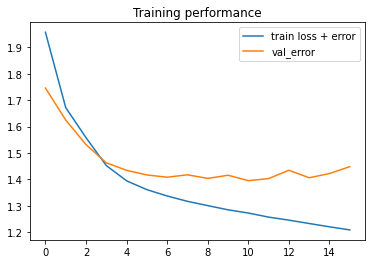

In [14]:
evaluationlib.show_loss_curves(history)

## Confusion matrix

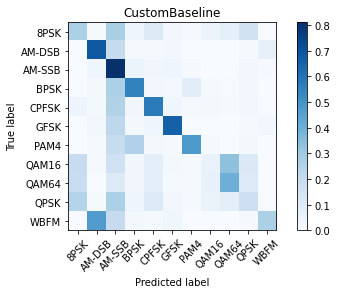

In [15]:
evaluationlib.plot_confusion_matrix(model, NEURAL_NETWORK_NAME, X_test, Y_test, BATCH_SIZE, classes)

## Confusion matrix for each SNR

Overall Accuracy:  0.09398216939078752


Overall Accuracy:  0.09722735674676525


Overall Accuracy:  0.09013785790031813


Overall Accuracy:  0.10751932536893886


Overall Accuracy:  0.14234104046242774


Overall Accuracy:  0.21625492302184032
Overall Accuracy:  0.2959512719455392


Overall Accuracy:  0.37136627906976744


Overall Accuracy:  0.4114305999290025


Overall Accuracy:  0.5363048166786485


Overall Accuracy:  0.6270878721859114


Overall Accuracy:  0.6624594302199783


Overall Accuracy:  0.676280834914611


Overall Accuracy:  0.6701492537313433
Overall Accuracy:  0.6628242074927954


Overall Accuracy:  0.6584032081662413
Overall Accuracy:  0.6690114772306553


Overall Accuracy:  0.6622790522752915


Overall Accuracy:  0.681650700073692


Overall Accuracy:  0.6530465949820788


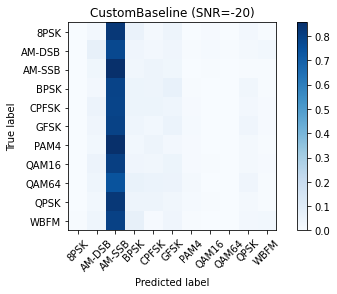

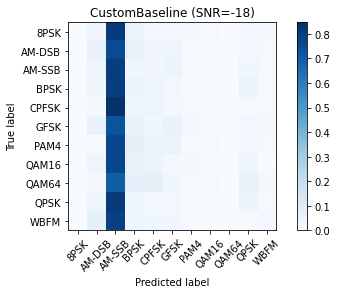

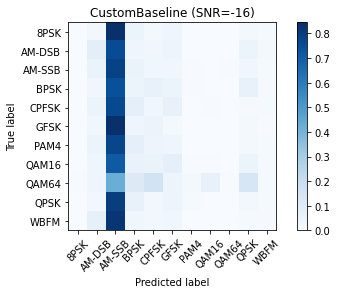

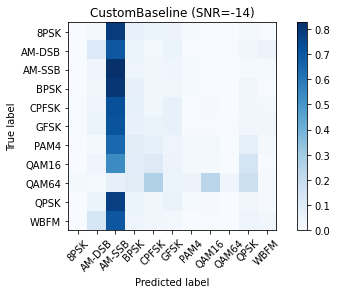

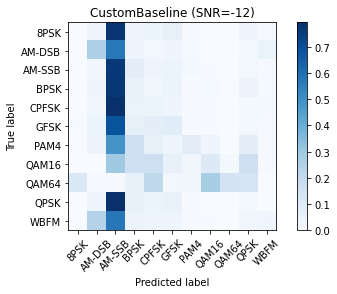

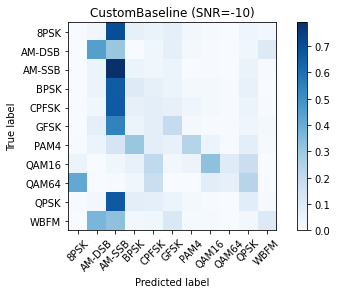

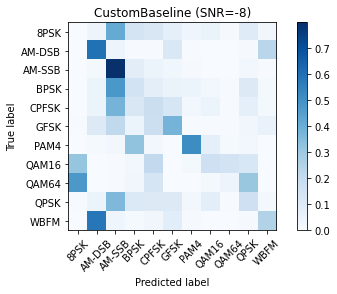

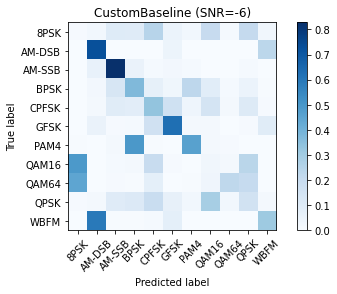

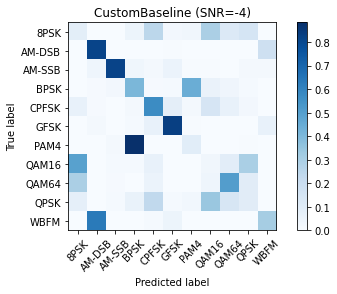

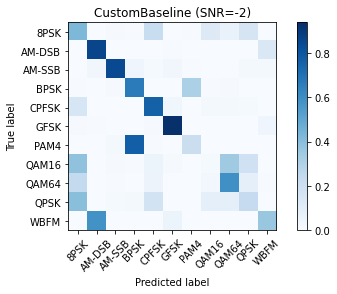

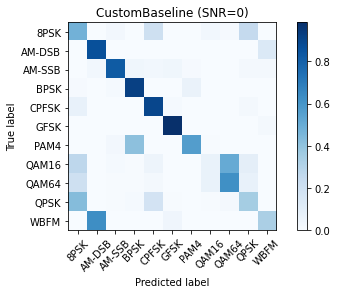

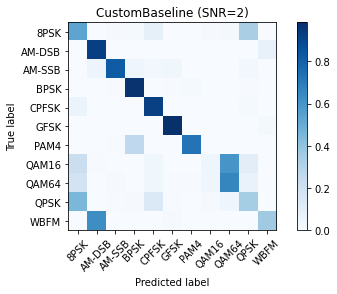

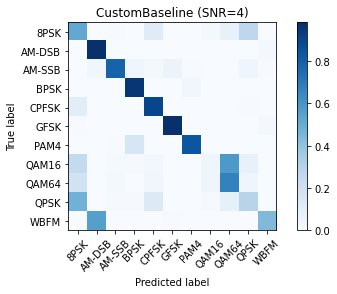

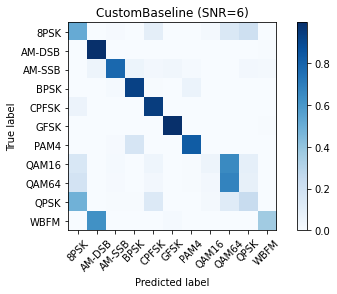

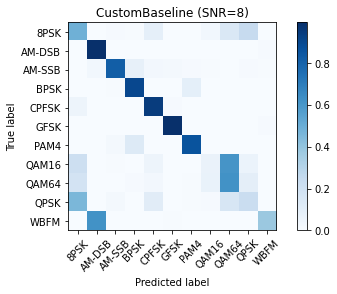

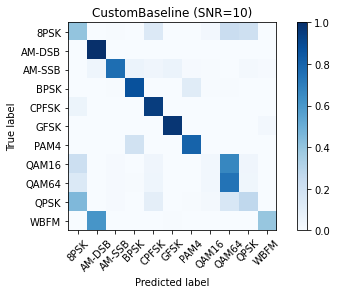

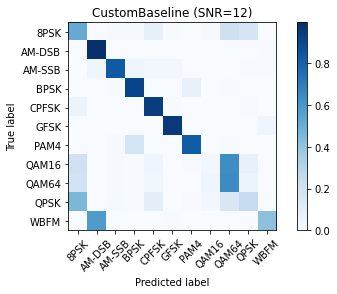

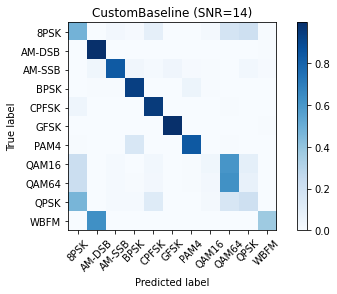

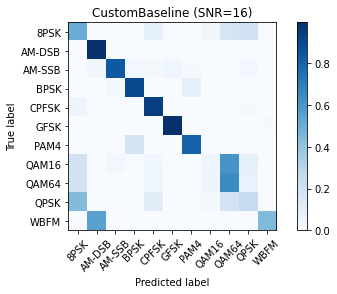

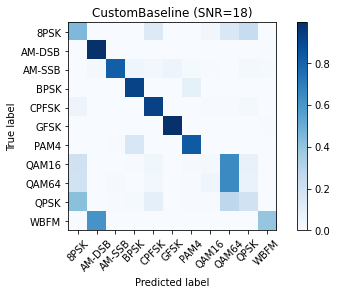

In [16]:
acc = evaluationlib.plot_confusion_matrix_each_snr(model, NEURAL_NETWORK_NAME, snrs, dataset_df, X_test, Y_test, test_index, classes)

## Accuracy performance

In [17]:
evaluationlib.accuracy_dataframe(acc)

,-20,-18,-16,-14,-12,-10,-8,-6,-4,-2,0,2,4,6,8,10,12,14,16,18
Accuracy %,9,9,9,10,14,21,29,37,41,53,62,66,67,67,66,65,66,66,68,65


In [18]:
import statistics

statistics.mean(acc.values())

0.4492854135893317

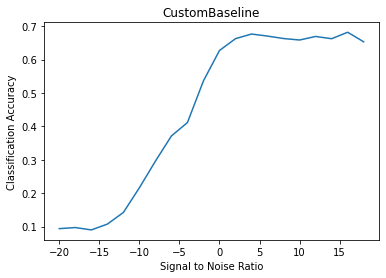

In [19]:
evaluationlib.accuracy_curve(snrs, acc, NEURAL_NETWORK_NAME)